Enhancements:
- Include price that assets were bought into the state
- Explore neutral penalty
- Encoding layer to control/learn state representation
- Improve stability of learning algorithms through the use of PPO, SAC
- Create short-term endpoints for trading windows during training and shuffle these windows
- Feature selection and hyperparameter tuning through validation search [Discount rate, ]
- More sophistication for state-propagation, e.g. Recurrent NN, Transformer

TODO:
- Walk-forward validation training
- Test evaluation of all models
- Use trained value network and pretrained policy network?


Consider:
- Recreating the table on Slide 41 of 56 from this set of lecture slides would be good for our purposes https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf


Final report
- Describe RL
- Describe LOB
- What metric are we trying to optimise
- Inputs
- Literature review
- Results

## 1. Overview

Note that for this Reinforcement Learning problem, the actions available to the agent are:
- 0: Short   (Have -1 asset)
- 1: Neutral (Have 0 asset)
- 2: Long    (Have 1 asset)

## 2. Install the necessary packages
- Models
- Commons
- Environment manager

In [1]:
!pip install -e requirements_installer

Obtaining file:///home/e0310734/code/requirements_installer
  Attempting uninstall: rl-finance
    Found existing installation: rl-finance 0.1
    Uninstalling rl-finance-0.1:
      Successfully uninstalled rl-finance-0.1
  Running setup.py develop for rl-finance


## 3. Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import random
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from rl_finance.environments import BaseEnvironment
from rl_finance.commons import Experience, ReplayMemory
from rl_finance.models import ActionValueNetwork, PolicyNetwork
from rl_finance.agents import DQN_Agent


%matplotlib inline
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
mlflow.set_tracking_uri("file:///home/e0310734/logs/mlruns")

## 4. Logger function

In [2]:
def mlflow_log(log, prefix, epoch=None):
    for k, v in log.items():
        if not hasattr(v, '__iter__'):
            mlflow.log_metric(f"{prefix}_{k}", v, step=epoch)
    
    # Log losses
    losses = log['losses']
    if losses:
        mlflow.log_metric(f"{prefix}_loss", losses[-1], step=epoch)
    
    # Log action history
    action_info = dict(pd.Series(log['episode_action_history']).value_counts())
    for action, action_count in action_info.items():
        mlflow.log_metric(f"{prefix}_action_{action}", action_count, step=epoch)

## 5. List the dataset locations

In [3]:
MONTH = 'jan'
datasets = []
dataset_scopes = ['minimal', 'minimal_window', 'full', 'full_window']
dataset_components = [
    'X_train.pt', 'X_validation.pt', 'X_test.pt',
    'y_train.pt', 'y_validation.pt', 'y_test.pt',
    'bid_train.pt', 'bid_val.pt', 'bid_test.pt',
    'ask_train.pt', 'ask_val.pt', 'ask_test.pt',
]

for dataset_scope in dataset_scopes:
    dataset = []
    for dataset_component in dataset_components:
        dataset.append("../data/processed_datasets/" + MONTH + "/" + dataset_scope + "/" + dataset_component)
    datasets.append(dataset)

## 6. State constant hyperparameters

In [4]:
ACTION_SPACE = [0, 1, 2]
OUTPUT_DIMS = 3
BATCH_SIZE = 512

N_EPOCHS = 150
EPOCH_TRAIN_START = 5  # Number of epochs to populate the ReplayMemory before we start sampling from it
LEARNING_RATE = 1e-6
REPLAY_MEMORY_SIZE = int(2**20)
DISCOUNT_RATE = 0.999
TARGET_UPDATE_INTERVAL = 12

TRADING_FEE = 3e-5
NEUTRAL_PENALTY = 1e-5

## 7. Select exploration-exploitation trade-off parameters

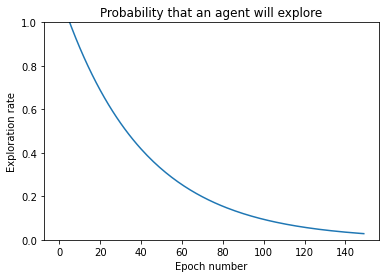

In [5]:
min_expl = 0.001
max_expl = 1.
expl_decay = 0.025
ers = []
for epoch in range(N_EPOCHS):
    exploration_rate = min_expl + (max_expl - min_expl) * np.exp(-expl_decay*(epoch - EPOCH_TRAIN_START))
    ers.append(exploration_rate)
pd.Series(ers).plot()
plt.title("Probability that an agent will explore")
plt.ylabel("Exploration rate")
plt.ylim((0,1))
plt.xlabel("Epoch number");

## 8. Reinforcement Learning: Deep Q Network

Start with a 1-pass algorithm then package it into a function and iterate over each of the hyperparameters

In [6]:
mlflow.set_experiment("DQN")

<Experiment: artifact_location='file:///home/e0310734/logs/mlruns/2', experiment_id='2', lifecycle_stage='active', name='DQN', tags={}>

In [ ]:
for dataset in datasets:
    for USE_MIDPRICE in [False, True]:
        with mlflow.start_run() as run:
            X_train, X_val, X_test, y_train, y_val, y_test, bid_train, bid_val, bid_test, ask_train, ask_val, ask_test = [torch.load(path) for path in dataset]

            INPUT_DIM = X_train.shape[-1]
            OUTPUT_DIM = len(ACTION_SPACE)

            train_env = BaseEnvironment(X_train, bid_train, ask_train, use_midprice=USE_MIDPRICE)
            val_env = BaseEnvironment(X_val, bid_val, ask_val, use_midprice=USE_MIDPRICE)
            test_env = BaseEnvironment(X_test, bid_test, ask_test, use_midprice=USE_MIDPRICE)
            replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE)

            action_value_network = ActionValueNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
            action_value_network.to(device)

            target_action_value_network = ActionValueNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
            target_action_value_network.load_state_dict(action_value_network.state_dict())
            target_action_value_network.to(device);

            agent = DQN_Agent(
                model = action_value_network,
                target_model = target_action_value_network,
                device = device,
                action_space = ACTION_SPACE,
                replay_memory = replay_memory,
                batch_size = BATCH_SIZE,
                min_expl = min_expl,
                max_expl = max_expl,
                expl_decay = expl_decay,
                epoch_train_start = EPOCH_TRAIN_START,
                learning_rate = LEARNING_RATE,
                discount_rate = DISCOUNT_RATE,
                target_update_interval = TARGET_UPDATE_INTERVAL
            )

            mlflow.log_params({
                'batch_size': BATCH_SIZE,
                'n_epochs': N_EPOCHS,
                'train_start_epoch': EPOCH_TRAIN_START,
                'learning_rate': LEARNING_RATE,
                'replay_memory_size': REPLAY_MEMORY_SIZE,
                'discount_rate': DISCOUNT_RATE,
                'target_update_interval': TARGET_UPDATE_INTERVAL,
                'use_midprice': USE_MIDPRICE,
                'trading_fee': TRADING_FEE,
                'neutral_penalty': NEUTRAL_PENALTY,
                'datascope': dataset[0].split("/")[2],
                'device': device,
                'input_dim': INPUT_DIM,
                'policy_network': str(action_value_network.linear_stack).replace("in_features=", "").replace("out_features=", "").replace(" ", "").replace("\n", "").replace(",bias=True", ""),
                'min_exploration_rate': min_expl,
                'max_exploration_rate': max_expl,
                'exploration_decay_rate': expl_decay,
            })

            train_save_path = "/tmp/train_dqn.pt"
            val_save_path = "/tmp/val_dqn.pt"
            walkforward_val_save_path = "/tmp/walkforward_val_dqn.pt"

            best_val_reward = float("-inf")

            for epoch in range(N_EPOCHS):
                train_log = agent.train(train_env)
                mlflow_log(train_log, prefix="train", epoch=epoch)

                val_log = agent.validate(val_env, can_explore=False, can_learn=False)
                mlflow_log(val_log, prefix="val", epoch=epoch)
                val_reward = val_log['episode_reward']
                if val_reward > best_val_reward:
                    best_val_reward = val_reward
                    action_value_network.save(val_save_path)
                    mlflow.log_artifact(val_save_path)

            # After all epochs, save training model
            action_value_network.save(train_save_path)
            mlflow.log_artifact(train_save_path)


            ### Run and log walkforward validation results - Last trained model
            # Val
            val_log_t = agent.validate(val_env, can_explore=True, can_learn=True)
            mlflow_log(val_log_t, prefix="val_last_train")

            # Test
            test_log_t = agent.test(test_env, can_explore=False, can_learn=True)
            mlflow_log(test_log_t, prefix="test_last_train")



            ### Run and log walkforward validation results - Best validation model
            agent.model.load_state_dict(torch.load(val_save_path))

            # Val
            val_log_v = agent.validate(val_env, can_explore=True, can_learn=True)
            mlflow_log(val_log_v, prefix="val_best_val")

            # Test
            test_log_v = agent.test(test_env, can_explore=False, can_learn=True)
            mlflow_log(test_log_v, prefix="test_best_val")